# Project B4: Effects of invasive species on native biodivesity

## Intro

Authors: Reelika Pärnpuu, Marta Miia Pärnpuu


Goals: 
1. The general goal is to prevent the spread of invasive species, mostly by analysing
and implementing new invasive species control methods. We will be working on data from
before the control methods have been implemented, but the project will go on to analyse the
same areas after implementation. 
2. A narrower goal would be to find ways for the plant to utilise Python in biology-related data mining, since biology work groups (at least in Tartu University) usually use R instead. To test how well Python can be utilized for biology-related data, we set the goal to look for general correlations in datasets provided for us.

Contents' guide:
1. Imports and cleanup
2. Getting familiar with the data, basic correlation graphs
3. Non-metric MultiDimensional Scaling
4. Biotic Novelty Index
5. Illustrative map
6. Correlation matrix



## 1. Imports and cleanup

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn import manifold
import numpy as np
import seaborn as sns
import plotnine as p9
import matplotlib.pylab as pylab
from scipy.stats import linregress
from scipy.spatial import distance


In [2]:
# paraameters for graphs
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}

pylab.rcParams.update(params)

In [39]:
#pd.set_option('display.max_columns', None) 

In [4]:
#excel file 1
EEB_samples = pd.ExcelFile('EEB_samples.xlsx') #file
sample = EEB_samples.parse('full_table') #sheet name

#excel file 2
EEB_soil_chemistry = pd.ExcelFile('EEB_soil_chemistry.xlsx')
soil = EEB_soil_chemistry.parse('Sheet1')
soil=soil.iloc[1:] #dropped a row that specified unit of measurement
soil= soil.reset_index(drop=True)
soil_df=soil[['ala_kood','pHKCl']]

#excel file 3
plant_survey = pd.ExcelFile('Plant_survey_2023_final.xlsx') 
plant = plant_survey.parse('Sheet1')

In [5]:
#since each sample had three repeats, we'll use the average of each triple; 
#following code finds the averages and renames them:
for i in range (1,14):
    for j in range(1,10):
        plant[plant['sample']=='EEB-RJ{}-{}'.format(i, j)]
        if j in range(1, 4):
            plant.loc[plant['sample'] == 'EEB-RJ{}-{}'.format(i, j), 'sample'] = 'INV-{}-R'.format(i)
        if j in range(4, 7): 
            plant.loc[plant['sample'] == 'EEB-RJ{}-{}'.format(i, j), 'sample'] = 'TRANS-{}-R'.format(i)
        if j in range(7, 10): 
            plant.loc[plant['sample'] == 'EEB-RJ{}-{}'.format(i, j), 'sample'] = 'NAT-{}-R'.format(i)
            
            
for i in range (1,12):
    for j in range(1,10):
        plant[plant['sample']=='EEB-SC{}-{}'.format(i, j)]
        if j in range(1, 4):
            plant.loc[plant['sample'] == 'EEB-SC{}-{}'.format(i, j), 'sample'] = 'INV-{}-S'.format(i)
        if j in range(4, 7): 
            plant.loc[plant['sample'] == 'EEB-SC{}-{}'.format(i, j), 'sample'] = 'TRANS-{}-S'.format(i)
        if j in range(7, 10): 
            plant.loc[plant['sample'] == 'EEB-SC{}-{}'.format(i, j), 'sample'] = 'NAT-{}-S'.format(i)
            
            
mean_df = plant.groupby('sample').mean()
#taimed=mean_df.copy()

In [6]:
#we'll create a coordinates' dataframe that only has the values we need
coord_df=sample[['new_code','lat', 'lon']]

#we'll also rename the codes used in the coordinate dataframe, 
#since that dataframe also uses the same codes as the plant dataframe previously did
for i in range (1,14):
    for j in range(1,10):
        coord_df[coord_df['new_code']=='EEB-RJ{}-{}'.format(i, j)]
        if j in range(1, 4):
            coord_df.loc[coord_df['new_code'] == 'EEB-RJ{}-{}'.format(i, j), 'new_code'] = 'INV-{}-R'.format(i)
        if j in range(4, 7): 
            coord_df.loc[coord_df['new_code'] == 'EEB-RJ{}-{}'.format(i, j), 'new_code'] = 'TRANS-{}-R'.format(i)
        if j in range(7, 10): 
            coord_df.loc[coord_df['new_code'] == 'EEB-RJ{}-{}'.format(i, j), 'new_code'] = 'NAT-{}-R'.format(i)
            
            
for i in range (1,12):
    for j in range(1,10):
        coord_df[coord_df['new_code']=='EEB-SC{}-{}'.format(i, j)]
        if j in range(1, 4):
            coord_df.loc[coord_df['new_code'] == 'EEB-SC{}-{}'.format(i, j), 'new_code'] = 'INV-{}-S'.format(i)
        if j in range(4, 7): 
            coord_df.loc[coord_df['new_code'] == 'EEB-SC{}-{}'.format(i, j), 'new_code'] = 'TRANS-{}-S'.format(i)
        if j in range(7, 10): 
            coord_df.loc[coord_df['new_code'] == 'EEB-SC{}-{}'.format(i, j), 'new_code'] = 'NAT-{}-S'.format(i)

coord_new=coord_df.groupby('new_code').mean()

In [7]:
full_plant_cover=mean_df.T.sum()
#we'll view the native and invasive species separetly in most cases
#the two invasive sp in this dataset are Reynoutria japonica (aka Japanese knotweed) and Solidago_canadensis (aka Canadian goldenrod)
invasive_sp=mean_df[['Reynoutria_japonica', 'Solidago_canadensis']]
native_sp=mean_df.drop(['Reynoutria_japonica', 'Solidago_canadensis'],axis=1)


native_cover=native_sp.T.sum()
invasive_cover=invasive_sp.T.sum()


In [8]:
mean_df['liigirikkus'] = mean_df.apply(lambda row: (row != 0).sum(), axis=1)
for index, row in mean_df.iterrows():
    for i in range(1,14):
        if '{}-R'.format(i) in index:
            mean_df.loc[index, 'pH']=soil_df[soil_df['ala_kood']=='EEB-RJ{}'.format(i)].pHKCl.values[0]
        if '{}-S'.format(i) in index:
            mean_df.loc[index, 'pH']=soil_df[soil_df['ala_kood']=='EEB-SC{}'.format(i)].pHKCl.values[0]
            
for index, row in mean_df.iterrows():
    if 'INV-' in index:
        mean_df.loc[index, 'invadeeritus']=1
    if 'TRANS-' in index:
        mean_df.loc[index, 'invadeeritus']=2
    if 'NAT-' in index:
        mean_df.loc[index, 'invadeeritus']=3

In [9]:
combined_df=pd.concat([mean_df,coord_new], axis=1)

soil.rename(columns={'P-AL': 'P_AL', 'K-AL': 'K_AL', 'Ca-AL': 'Ca_AL', 'Mg-AL': 'Mg_AL', 'N -Kjeldahl': 'N_Kjel', 'C-Tjurin': 'C_Tjur'}, inplace=True)

for index, row in combined_df.iterrows():
    for i in range(1,14):
        if '{}-R'.format(i) in index:
            combined_df.loc[index, 'P_AL']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].P_AL.values[0]
            combined_df.loc[index, 'K_AL']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].K_AL.values[0]
            combined_df.loc[index, 'Ca_AL']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].Ca_AL.values[0]
            combined_df.loc[index, 'Mg_AL']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].Mg_AL.values[0]
            combined_df.loc[index, 'N_Kjel']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].N_Kjel.values[0]
            combined_df.loc[index, 'C_Tjur']=soil[soil['ala_kood']=='EEB-RJ{}'.format(i)].C_Tjur.values[0]
        if '{}-S'.format(i) in index:
            combined_df.loc[index, 'P_AL']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].P_AL.values[0]
            combined_df.loc[index, 'K_AL']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].K_AL.values[0]
            combined_df.loc[index, 'Ca_AL']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].Ca_AL.values[0]
            combined_df.loc[index, 'Mg_AL']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].Mg_AL.values[0]
            combined_df.loc[index, 'N_Kjel']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].N_Kjel.values[0]
            combined_df.loc[index, 'C_Tjur']=soil[soil['ala_kood']=='EEB-SC{}'.format(i)].C_Tjur.values[0]
            
            
combined_df[['invadeeritus','lat','lon']]
species_cols = [col for col in combined_df.columns if col not in ['liigirikkus',
 'pH',
 'invadeeritus',
 'lat',
 'lon',
 'P_AL',
 'K_AL',
 'Ca_AL',
 'Mg_AL',
 'N_Kjel',
 'C_Tjur']]

mean_coverage_by_area = combined_df.groupby('invadeeritus')[species_cols].mean()


In [10]:
# adding invasive coverage, native coverage and full plant coverage to the data frame
combined_df=combined_df.copy()

combined_df.loc[:, 'invasiivsete_katvus'] = invasive_cover.values
combined_df.loc[:, 'tavaliste_katvus'] = native_cover.values
combined_df.loc[:, 'kogu_katvus'] = full_plant_cover.values


In [11]:
tulbad=['liigirikkus', 'pH', 'invadeeritus', 'lat', 'lon', 'P_AL', 'K_AL', 'Ca_AL', 'Mg_AL',
       'N_Kjel', 'C_Tjur']
väiksem_asi=combined_df[tulbad]

## 2. Basic correlation graphs, getting familiar with the data

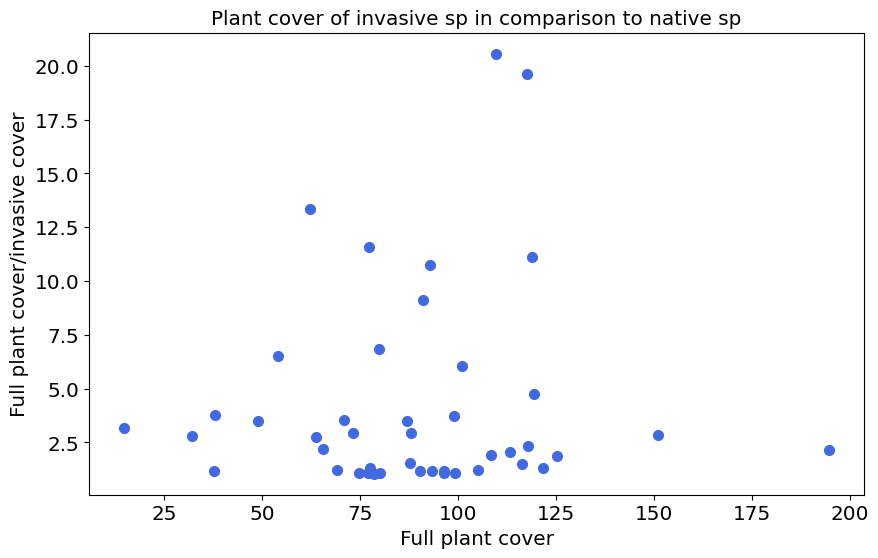

In [12]:
plt.plot(full_plant_cover,full_plant_cover/invasive_cover, marker='o', linestyle='', markersize=7, color='royalblue')
plt.xlabel('Full plant cover')
plt.ylabel('Full plant cover/invasive cover')
plt.title('Plant cover of invasive sp in comparison to native sp')
plt.show()

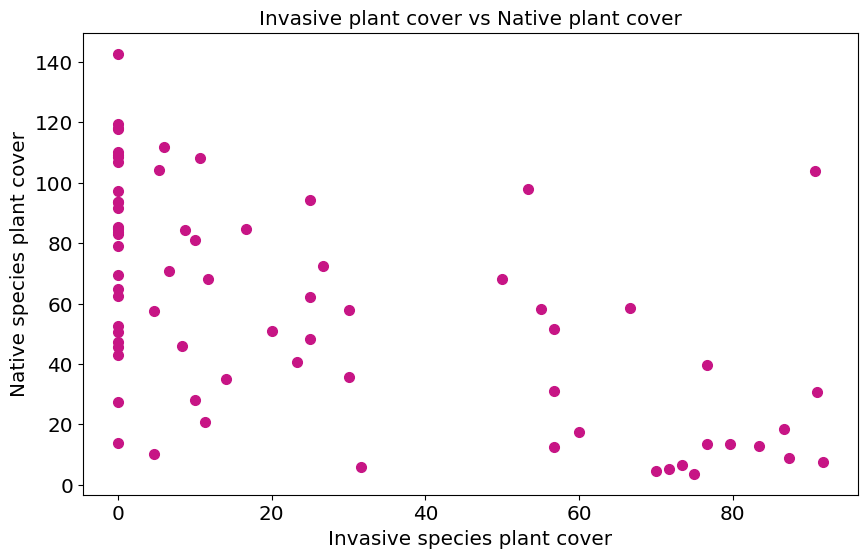

In [13]:
plt.plot(invasive_cover,native_cover, marker='o', linestyle='', markersize=7, color='mediumvioletred')
plt.xlabel('Invasive species plant cover')
plt.ylabel('Native species plant cover')
plt.title('Invasive plant cover vs Native plant cover')
plt.show()

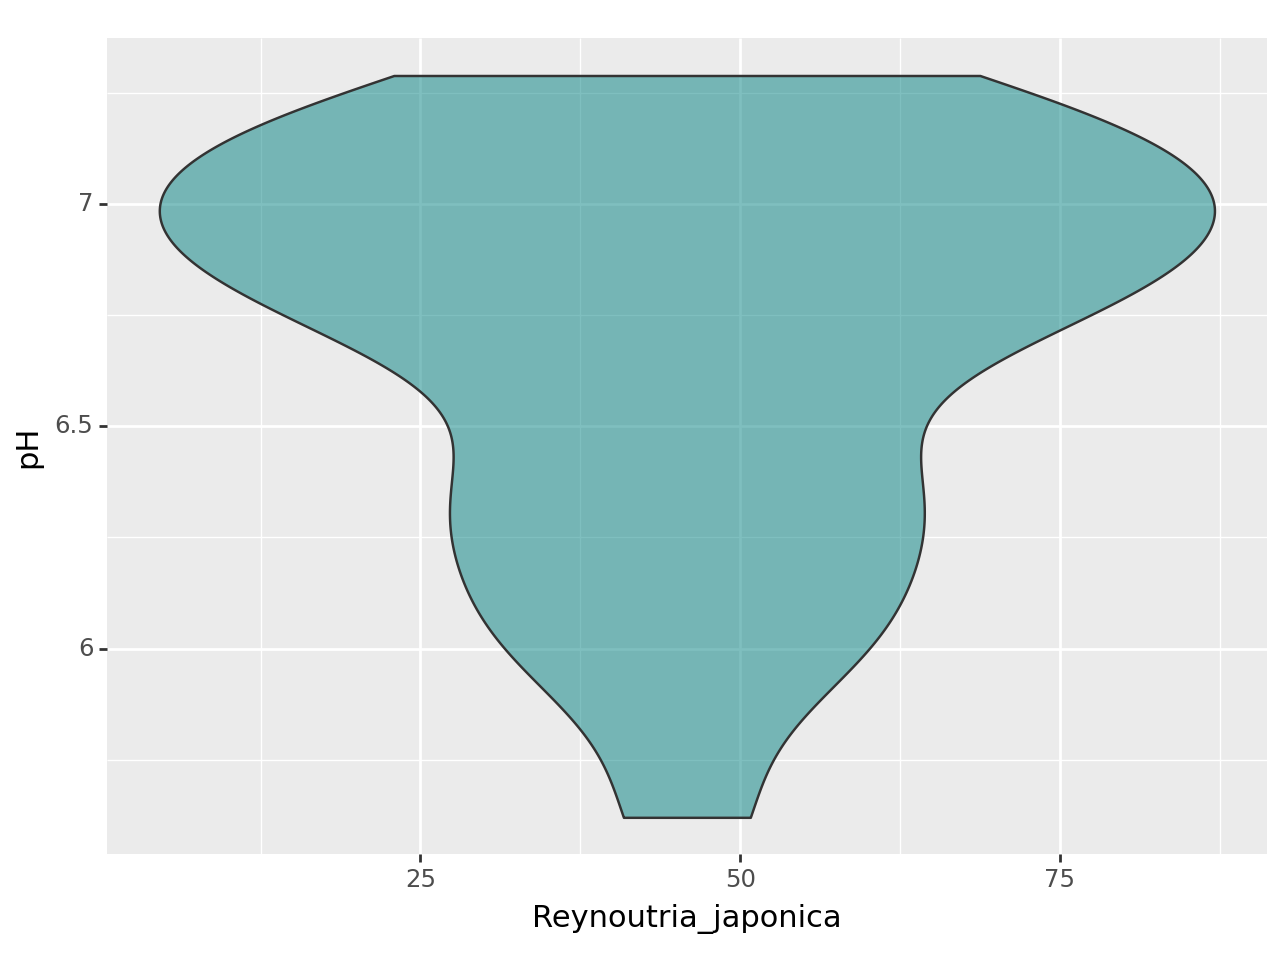

<Figure Size: (640 x 480)>

In [14]:
(p9.ggplot(
    data = mean_df, 
    mapping = p9.aes(x = 'Reynoutria_japonica', y = 'pH')
) + 
    p9.geom_violin(fill='teal',alpha=0.5))


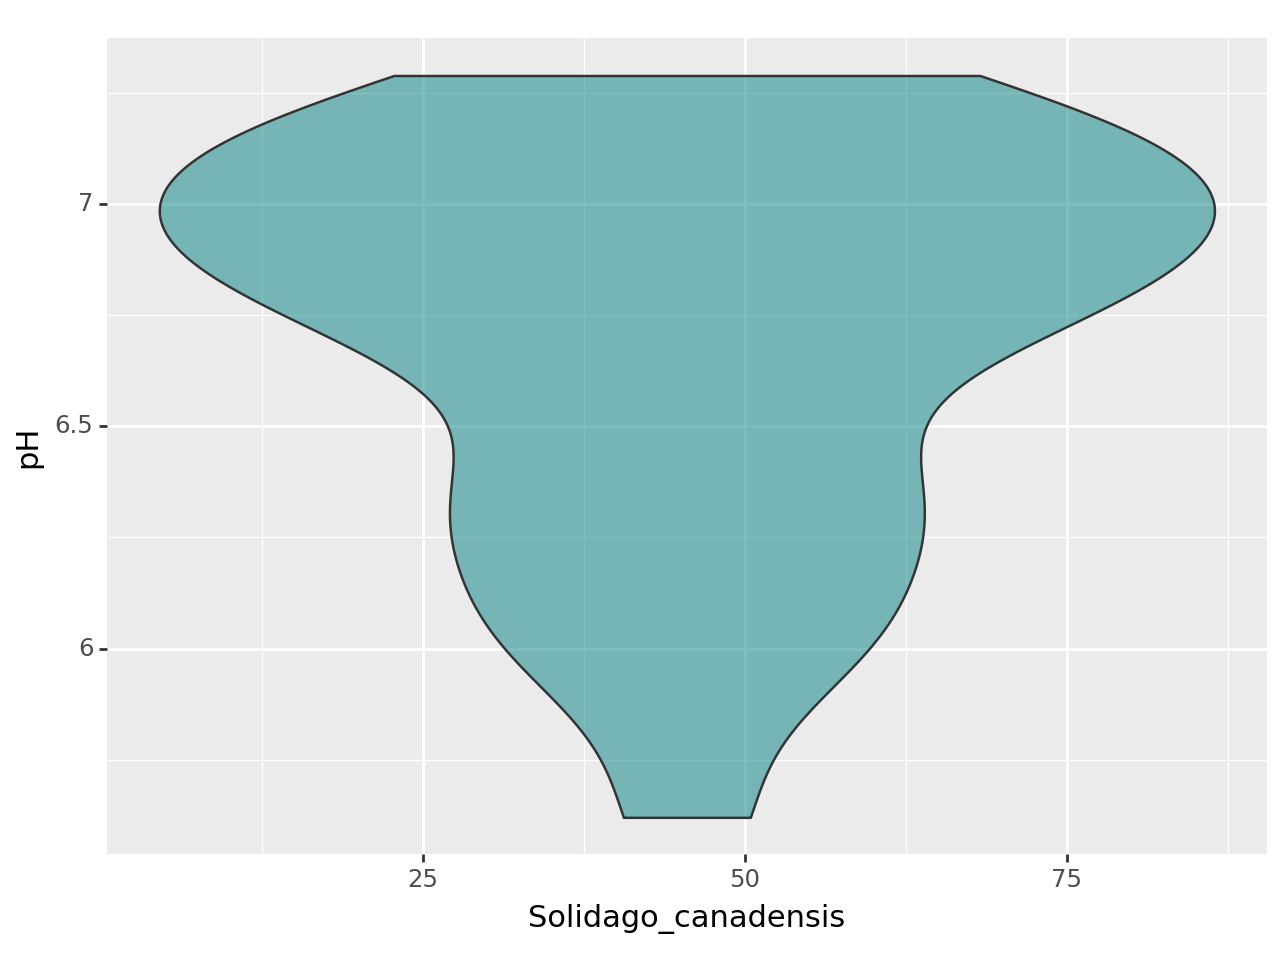

<Figure Size: (640 x 480)>

In [15]:
(p9.ggplot(
    data = mean_df, 
    mapping = p9.aes(x = 'Solidago_canadensis', y = 'pH')
) + 
    p9.geom_violin(fill='teal',alpha=0.5))


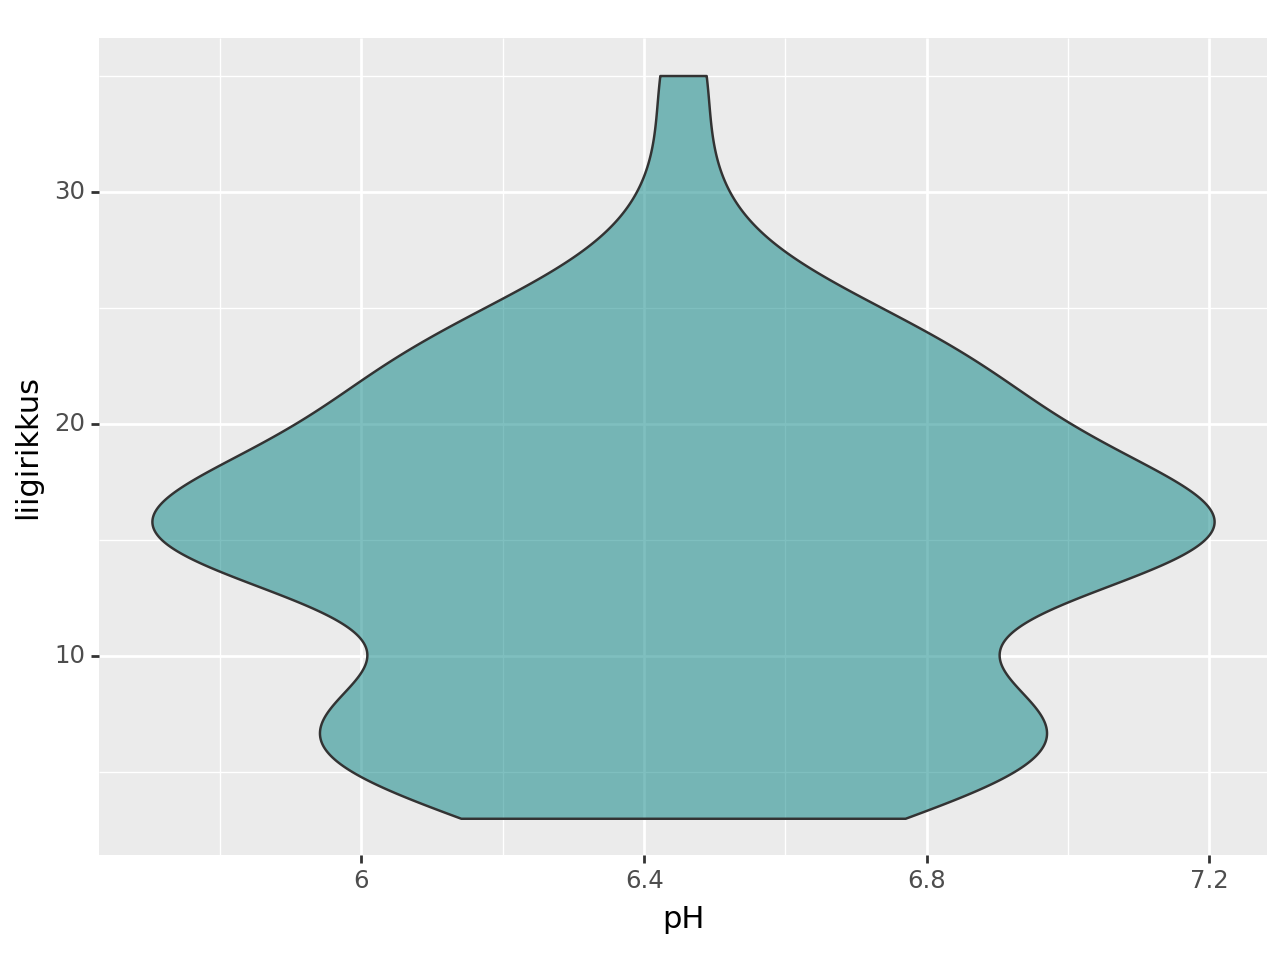

<Figure Size: (640 x 480)>

In [16]:
(p9.ggplot(
    data = mean_df, 
    mapping = p9.aes(y = 'liigirikkus', x = 'pH')
) + 
    p9.geom_violin(fill='teal',alpha=0.5))


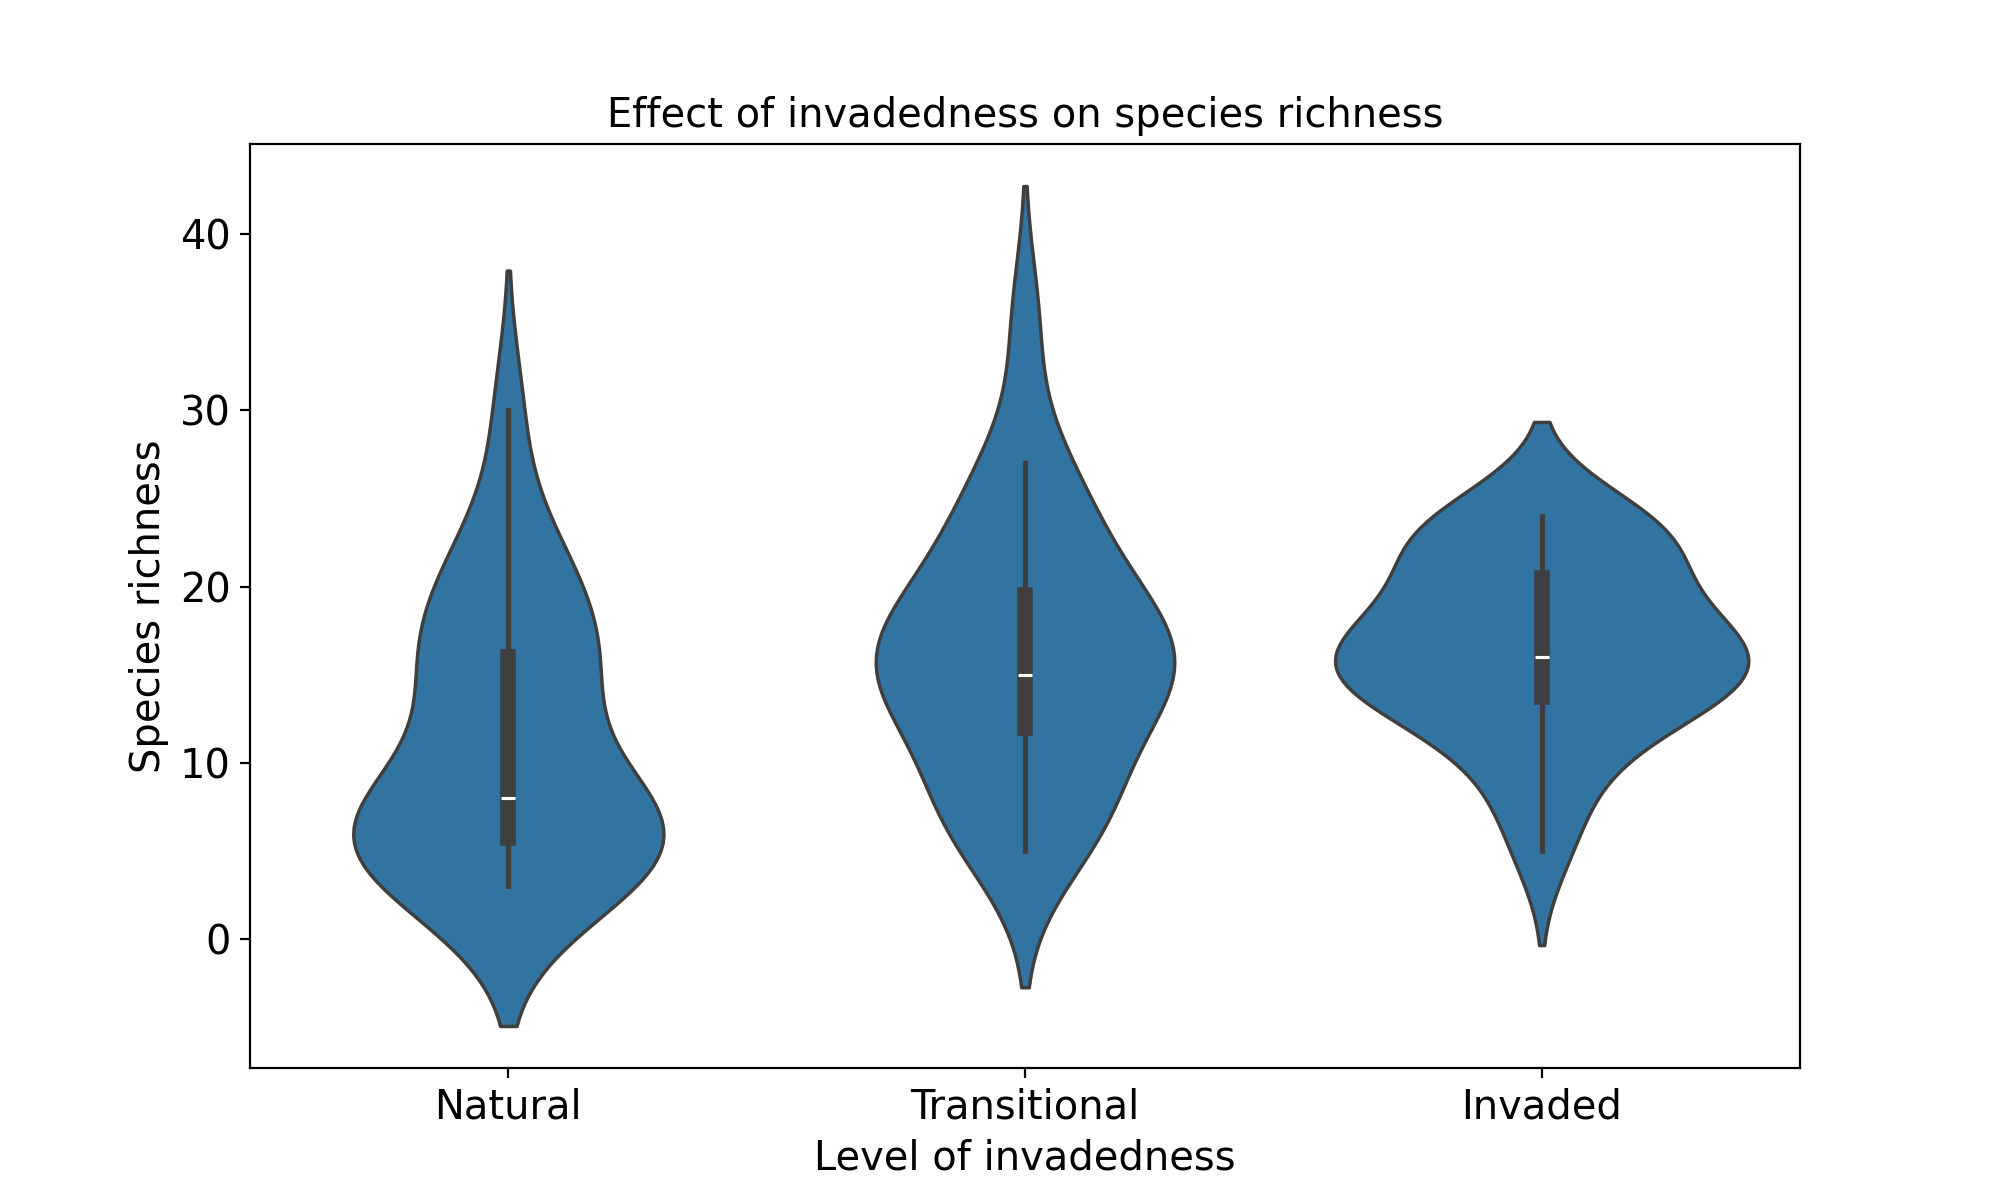

In [17]:
import seaborn as sns
plt.figure(figsize=(10,6))
inv_vs_rich=sns.violinplot(x='invadeeritus', y='liigirikkus', data=väiksem_asi)
#plt.plot(1,inv.liigirikkus.mean(),'k+',label='inv keskmine')
#plt.plot(2,trans.liigirikkus.mean(),'m+',label='trans keskmine')
#plt.plot(3,nat.liigirikkus.mean(),'g+',label='nat keskmine')
plt.title('Effect of invadedness on species richness')
plt.ylabel('Species richness')
plt.xlabel('Level of invadedness')
plt.xticks(np.arange(3),["Natural","Transitional","Invaded"])
#plt.legend()
plt.show()


fig =inv_vs_rich.get_figure()
#fig.savefig('inv_vs_rich.png',dpi=300)  


## 3. Non-metric MultiDimensional Scaling

In [18]:
# In order to apply NDMS, we'll need to convert the data matrix (n sample units × p species) into an n x n distance matrix
distances = pairwise_distances(mean_df.values)

# Also converting the distance matrix into a DataFrame for better visualization
distances_df = pd.DataFrame(distances, index=mean_df.index, columns=mean_df.index)

In [19]:
combined_df_copy=combined_df.copy()

combined_df_copy.loc[:, 'invasive_cover'] =invasive_cover.values
combined_df_copy.loc[:, 'native_cover'] = native_cover.values
combined_df_copy.loc[:, 'full_plant_cover'] = full_plant_cover.values

combined_df_dist = pd.DataFrame(pairwise_distances(combined_df_copy.values), index=combined_df_copy.index, columns=combined_df_copy.index)

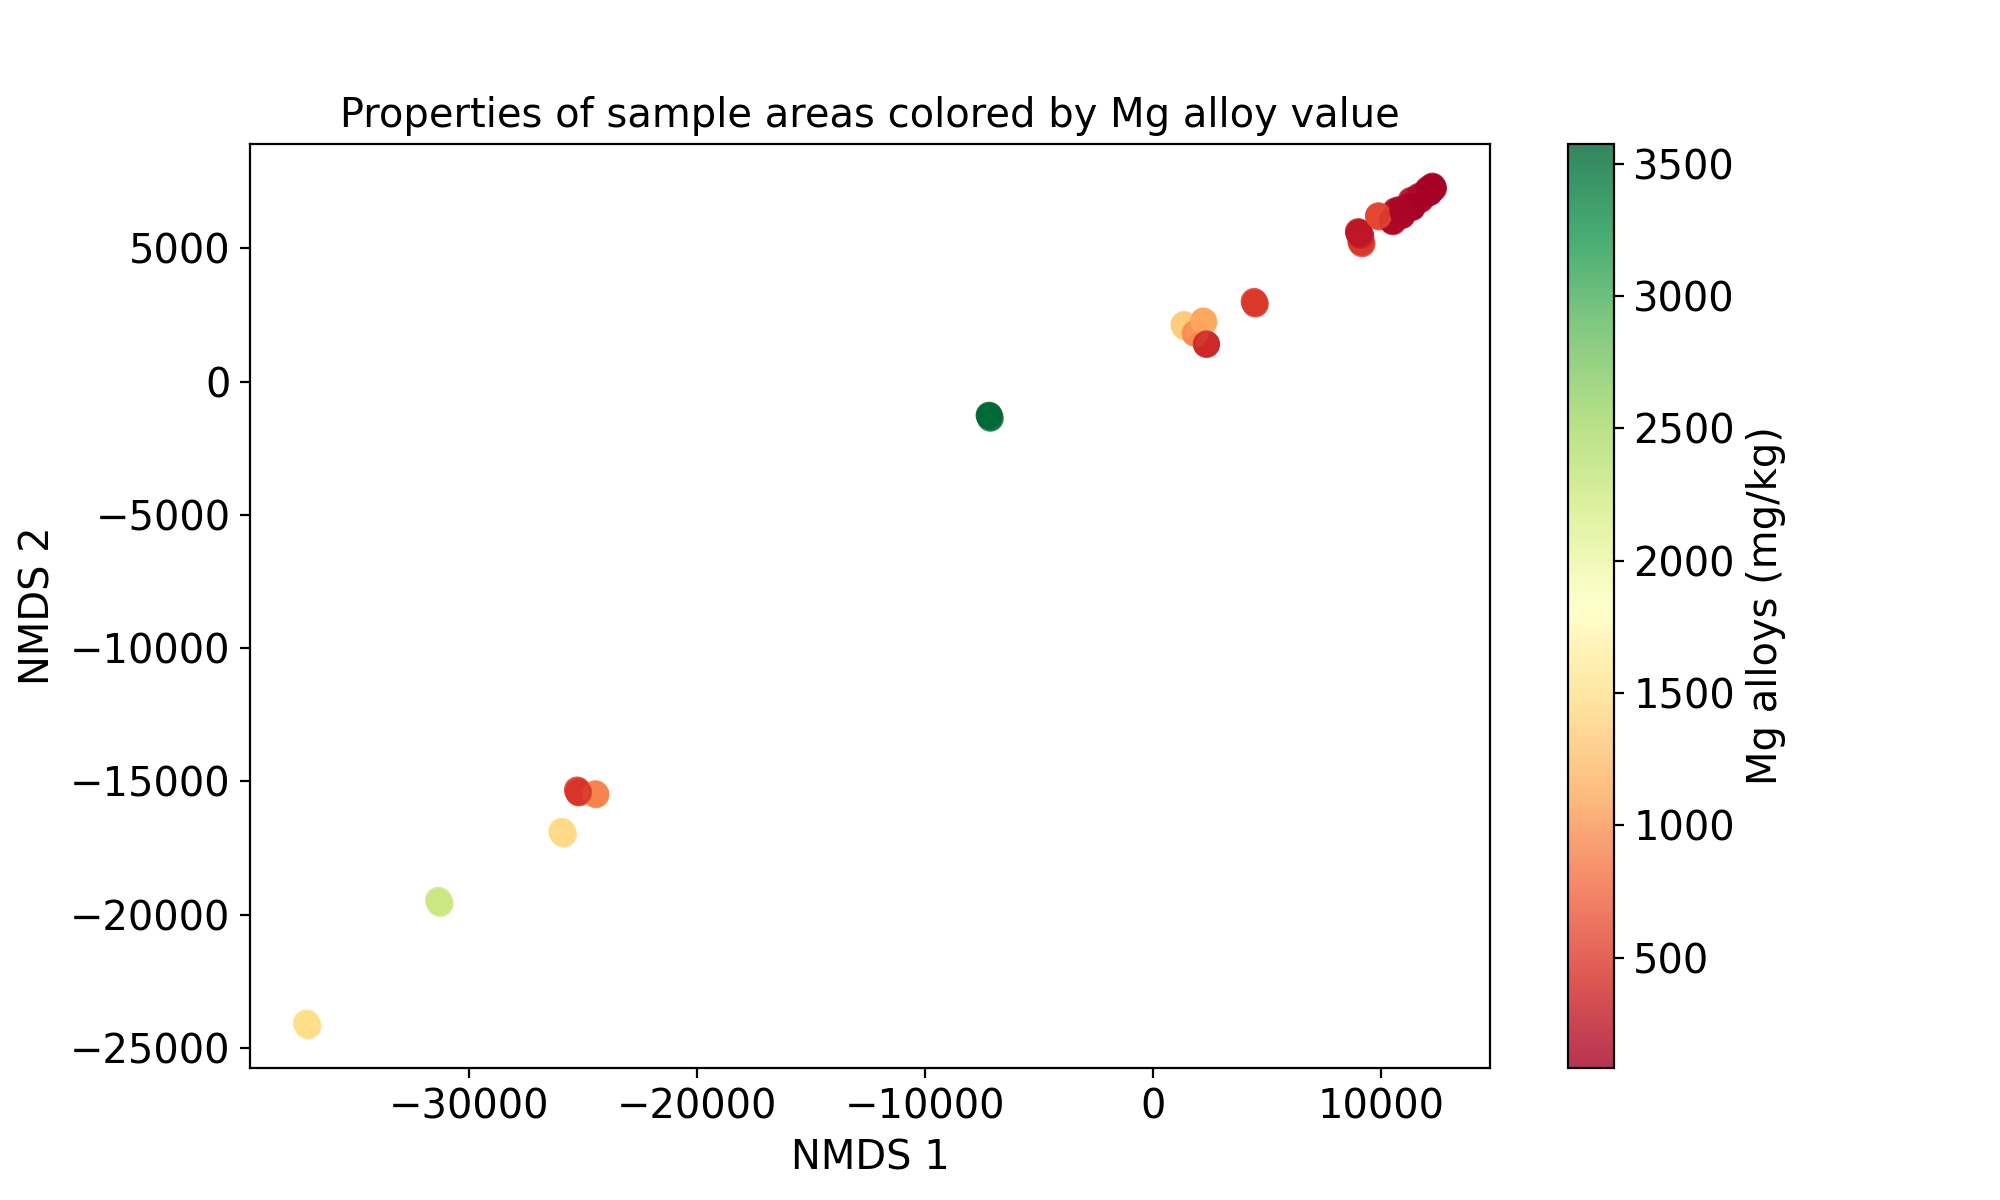

In [20]:
plt.figure(figsize=(10,6))
#plt.figure(dpi=110)
mds = manifold.MDS(n_components=2, dissimilarity='precomputed',normalized_stress='auto')
emb = mds.fit_transform(combined_df_dist)
värv=combined_df_copy.Mg_AL.values

plt.scatter(emb[:, 0], emb[:, 1],c=värv, cmap='RdYlGn',s=75,alpha=0.8)
plt.xlabel('NMDS 1')
plt.ylabel('NMDS 2')
plt.title('Properties of sample areas colored by Mg alloy value')
plt.colorbar(label='Mg alloys (mg/kg)')
plt.show()

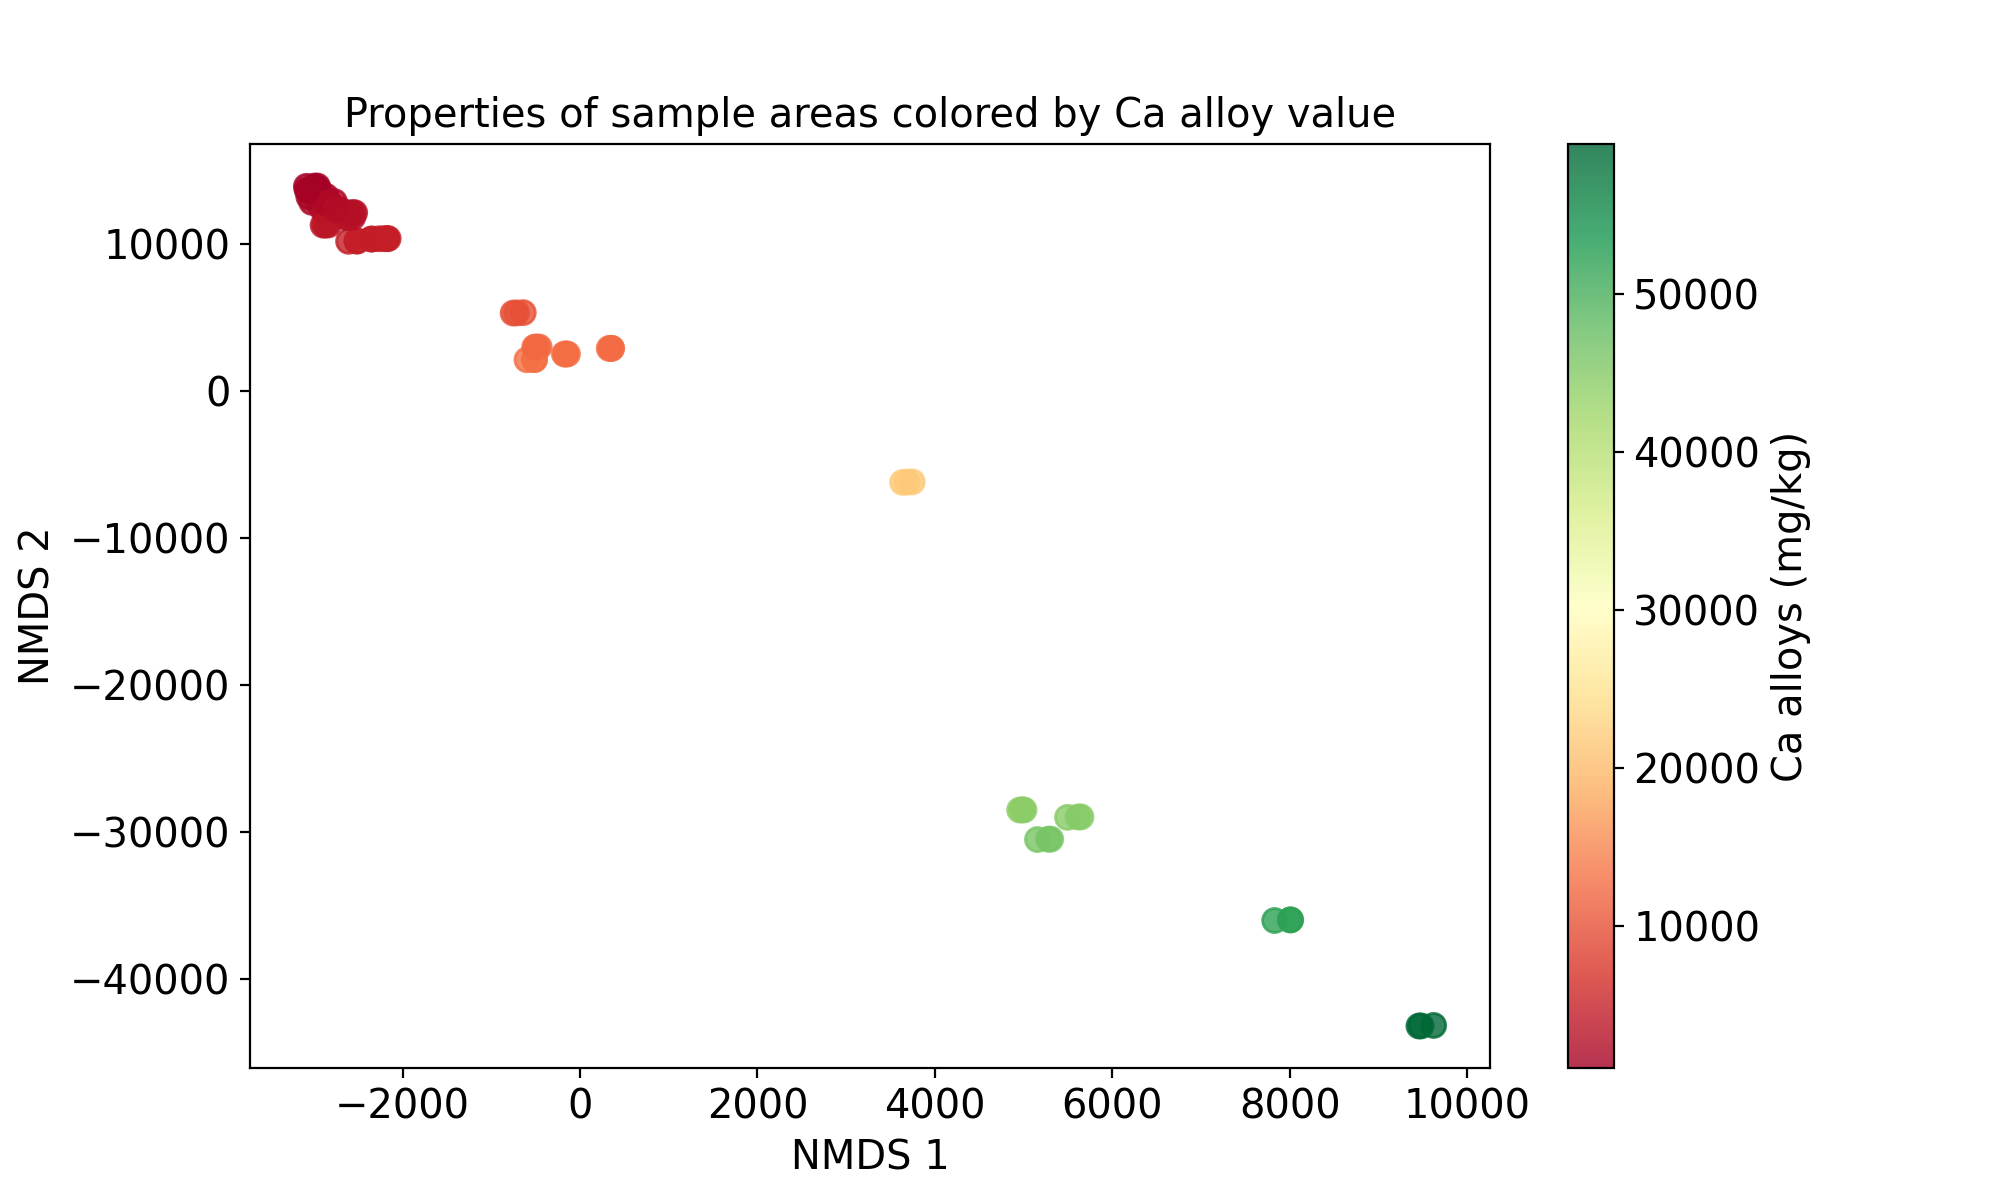

In [21]:
plt.figure(figsize=(10,6))
#plt.figure(dpi=110)
mds = manifold.MDS(n_components=2, dissimilarity='precomputed',normalized_stress='auto')
emb = mds.fit_transform(combined_df_dist)
värv=combined_df_copy.Ca_AL.values

plt.scatter(emb[:, 0], emb[:, 1],c=värv, cmap='RdYlGn',s=75,alpha=0.8)
plt.xlabel('NMDS 1')
plt.ylabel('NMDS 2')
plt.title('Properties of sample areas colored by Ca alloy value')
plt.colorbar(label='Ca alloys (mg/kg)')
#plt.savefig('Ca_AL_väärtused.png',dpi=300,bbox_inches='tight')
plt.show()


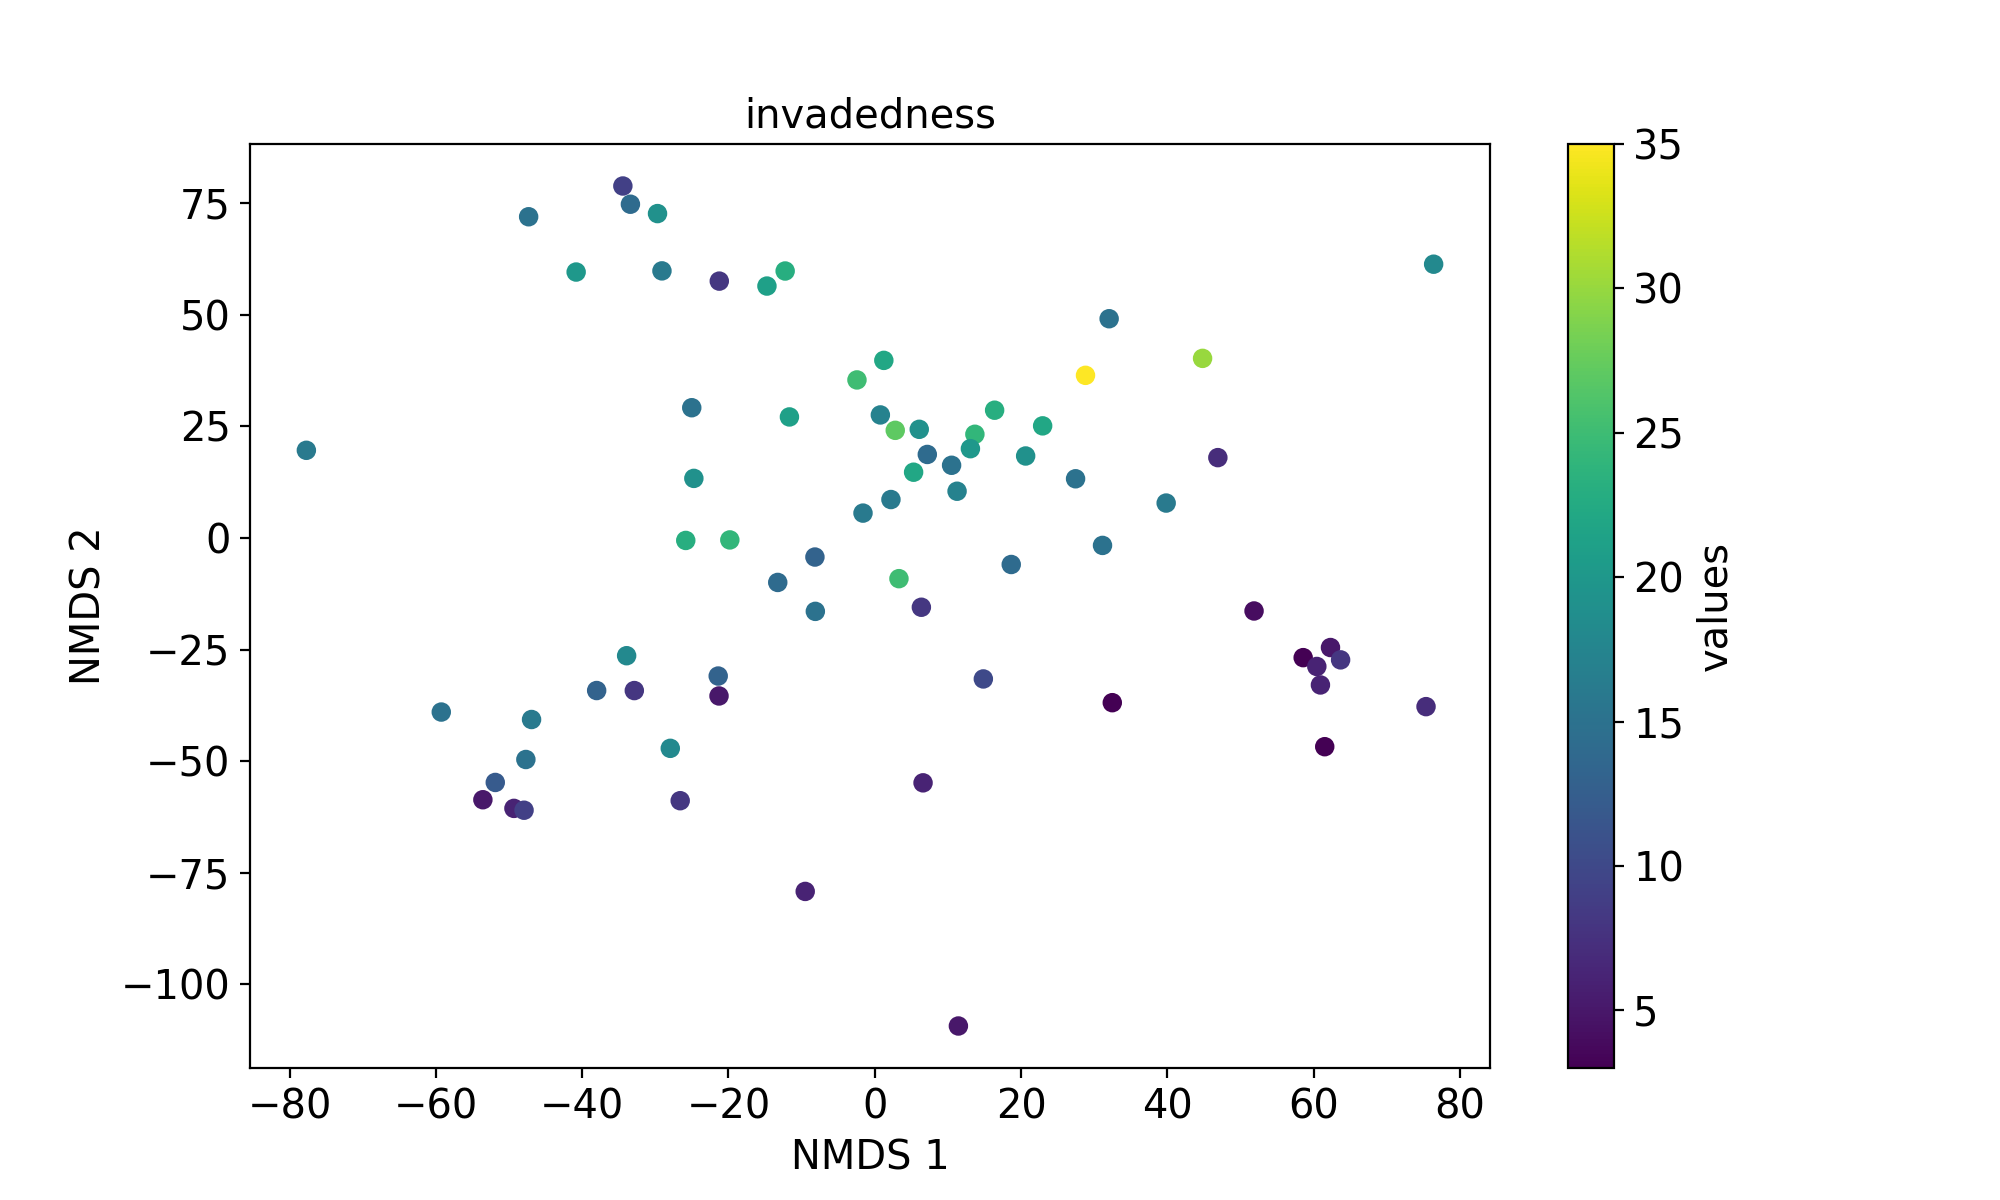

In [42]:

mds = manifold.MDS(n_components=2, dissimilarity='precomputed',normalized_stress="auto")
embedding = mds.fit_transform(distances_df)
pH=combined_df.liigirikkus.values

plt.scatter(embedding[:, 0], embedding[:, 1],c=pH, cmap='viridis')
plt.xlabel('NMDS 1')
plt.ylabel('NMDS 2')
plt.colorbar(label='values')
plt.title('invadedness')
plt.show()

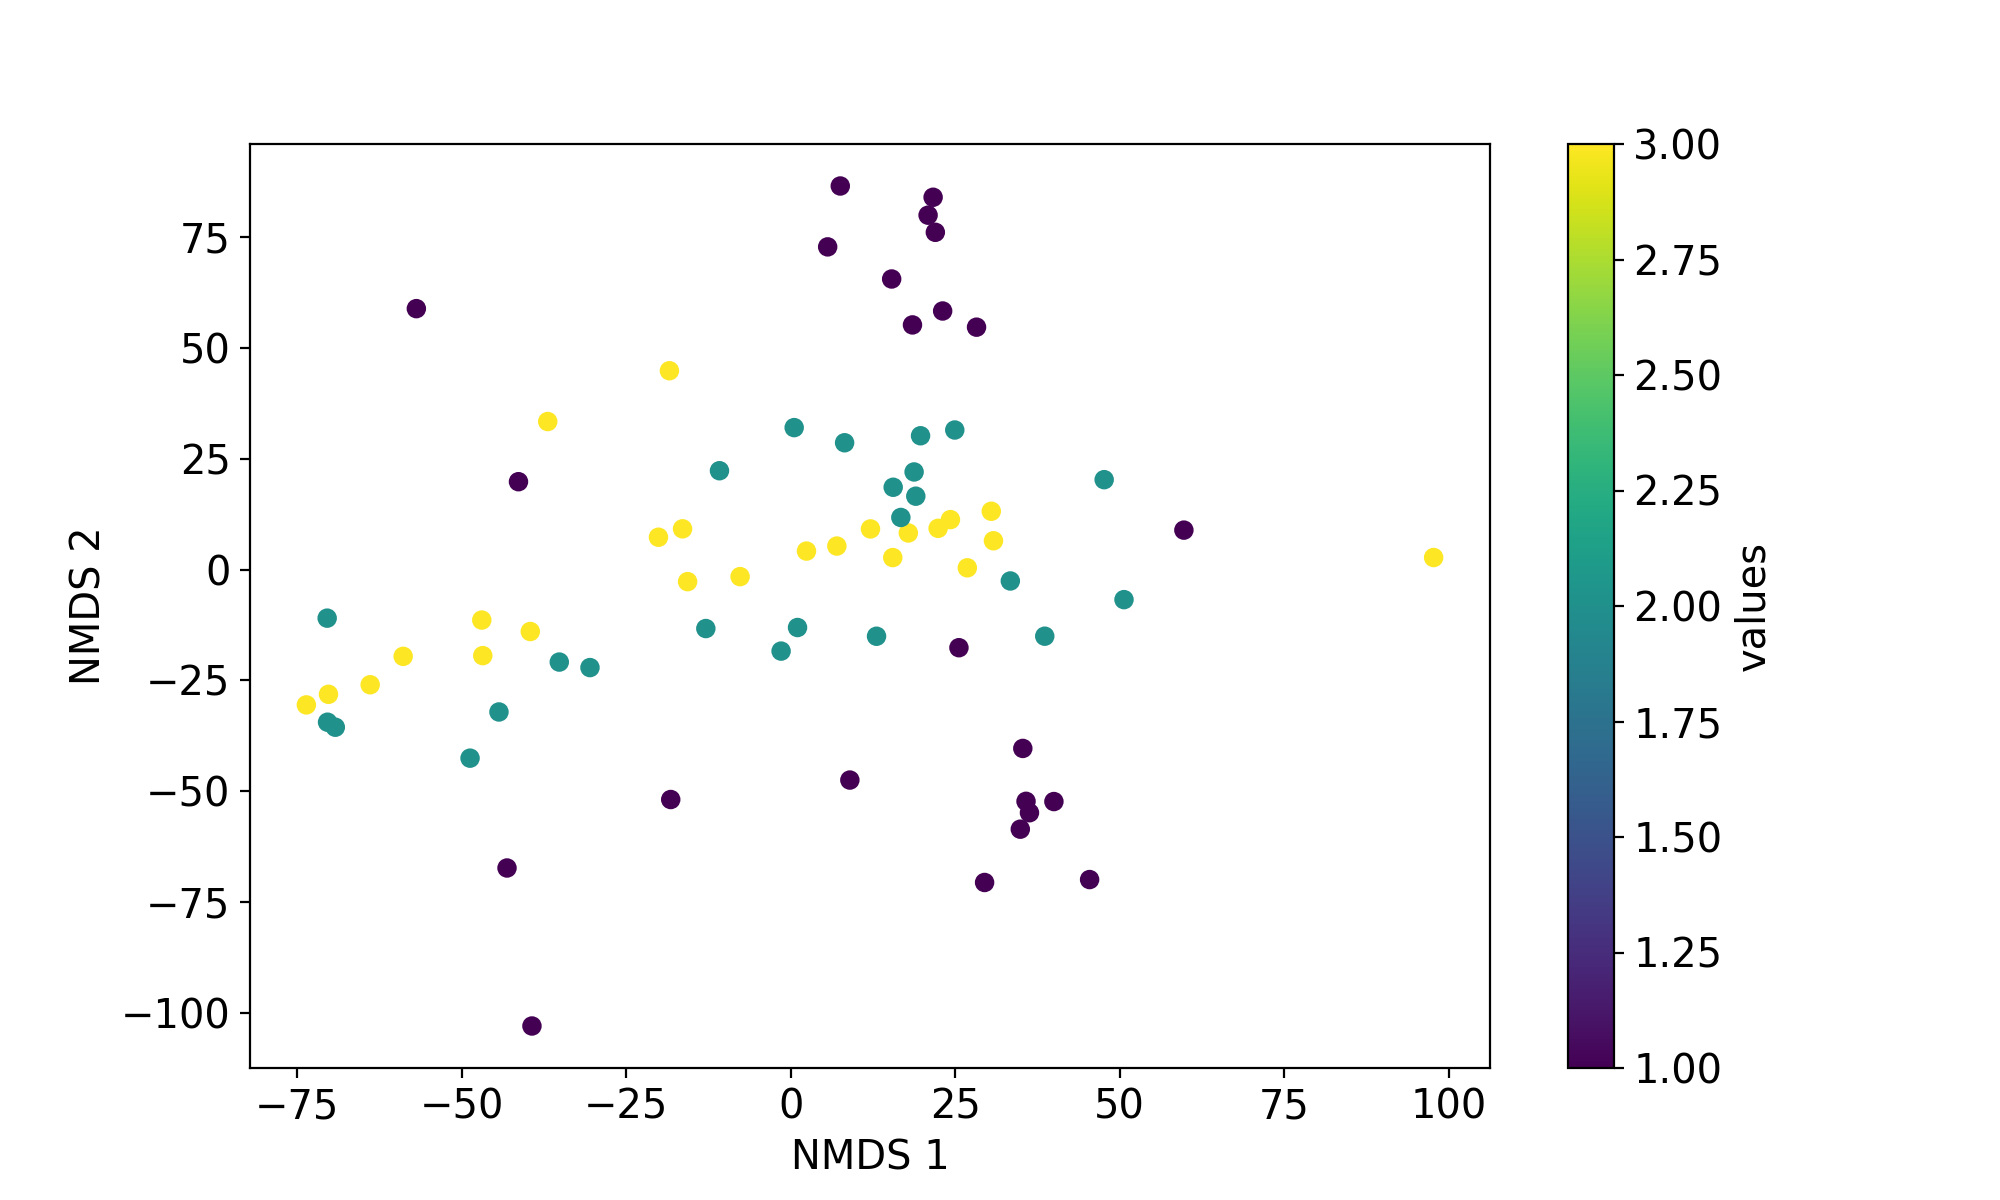

In [41]:

invadeeritus=combined_df.invadeeritus.values

plt.scatter(embedding[:, 0], embedding[:, 1],c=invadeeritus, cmap='viridis')
plt.xlabel('NMDS 1')
plt.ylabel('NMDS 2')
plt.colorbar(label='values')

plt.show()

- 1= INV
- 2=TRANS
- 3=NAT

## 4. Calculating BNI

In [23]:
plants_only=mean_df.drop(labels=["liigirikkus","pH","invadeeritus"], axis=1)

maatriks= pd.ExcelFile('YSI_matrix.xlsx')
YSI= maatriks.parse('Sheet4')

YSI['invasiivsus'] = YSI['invasiivsus'].apply(lambda x: 0 if x == 1 else 1)
com=plants_only


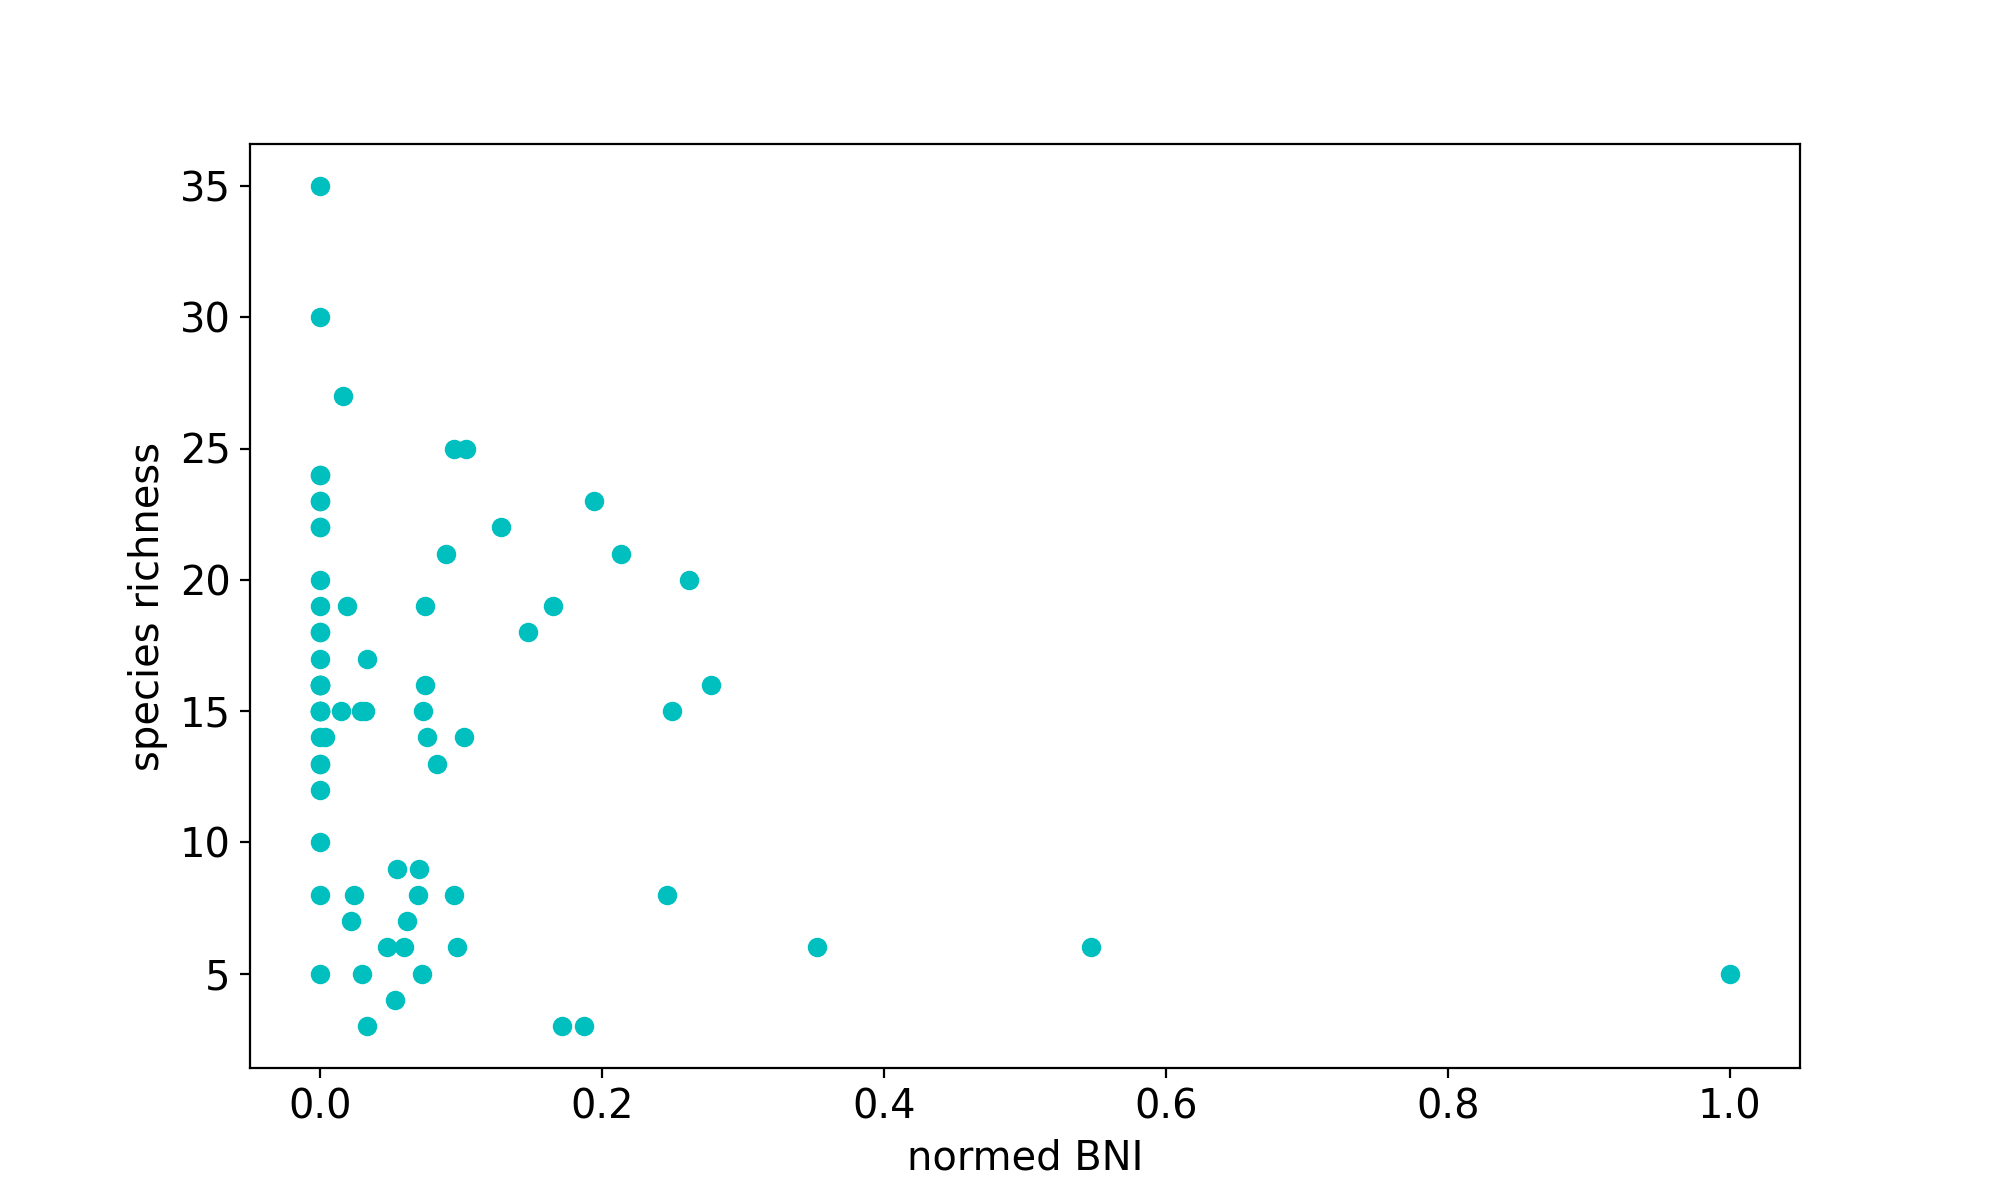

In [36]:
com=plants_only.values
pl=plants_only.T

distance = pairwise_distances(pl.values)
rpi = pd.DataFrame(YSI) #/ np.max(YSI, axis=0)

distances_mat = pd.DataFrame(distance)
t_dist=np.reshape(distances_mat.values,(1,-1))
r = YSI['invasiivsus'].values
n = len(r)
c_ij = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        
        c_ij[i, j] = 1 - min(r[i], r[j])

df_c_ij = pd.DataFrame(c_ij)
dxc = distances_mat *c_ij
BNI = np.apply_along_axis(lambda x: np.dot(x, np.dot(dxc, x)), axis=1, arr=com)/2 

BNI_norm=BNI/BNI.max() #normation
plt.plot(BNI_norm, mean_df['liigirikkus'],'co')
plt.xlabel('normed BNI')
plt.ylabel('species richness')
plt.show()

## 5. Map illustrating sampling areas

In [25]:
import folium

# Create a map centered at an initial location
initial_latitude=58.595272
initial_longitude=25.013607
map = folium.Map(location=[initial_latitude, initial_longitude], zoom_start=7)

# Add points to the map
for index, row in coord_new.iterrows():
    folium.CircleMarker([row['lat'], row['lon']], color="darkblue",
        radius=10,
        fill=True,
        fill_color="cadetblue",
        fill_opacity=0.6,
        ).add_to(map)
# Display the map
map
#map.save('map.html')

## 6. Correlation matrix

In [26]:
väiksem_asi = väiksem_asi.copy()
väiksem_asi.loc[:, 'invasiivsete_katvus'] = invasive_cover.values
väiksem_asi.loc[:, 'tavaliste_katvus'] = native_cover.values
väiksem_asi.loc[:, 'kogu_katvus'] = full_plant_cover.values

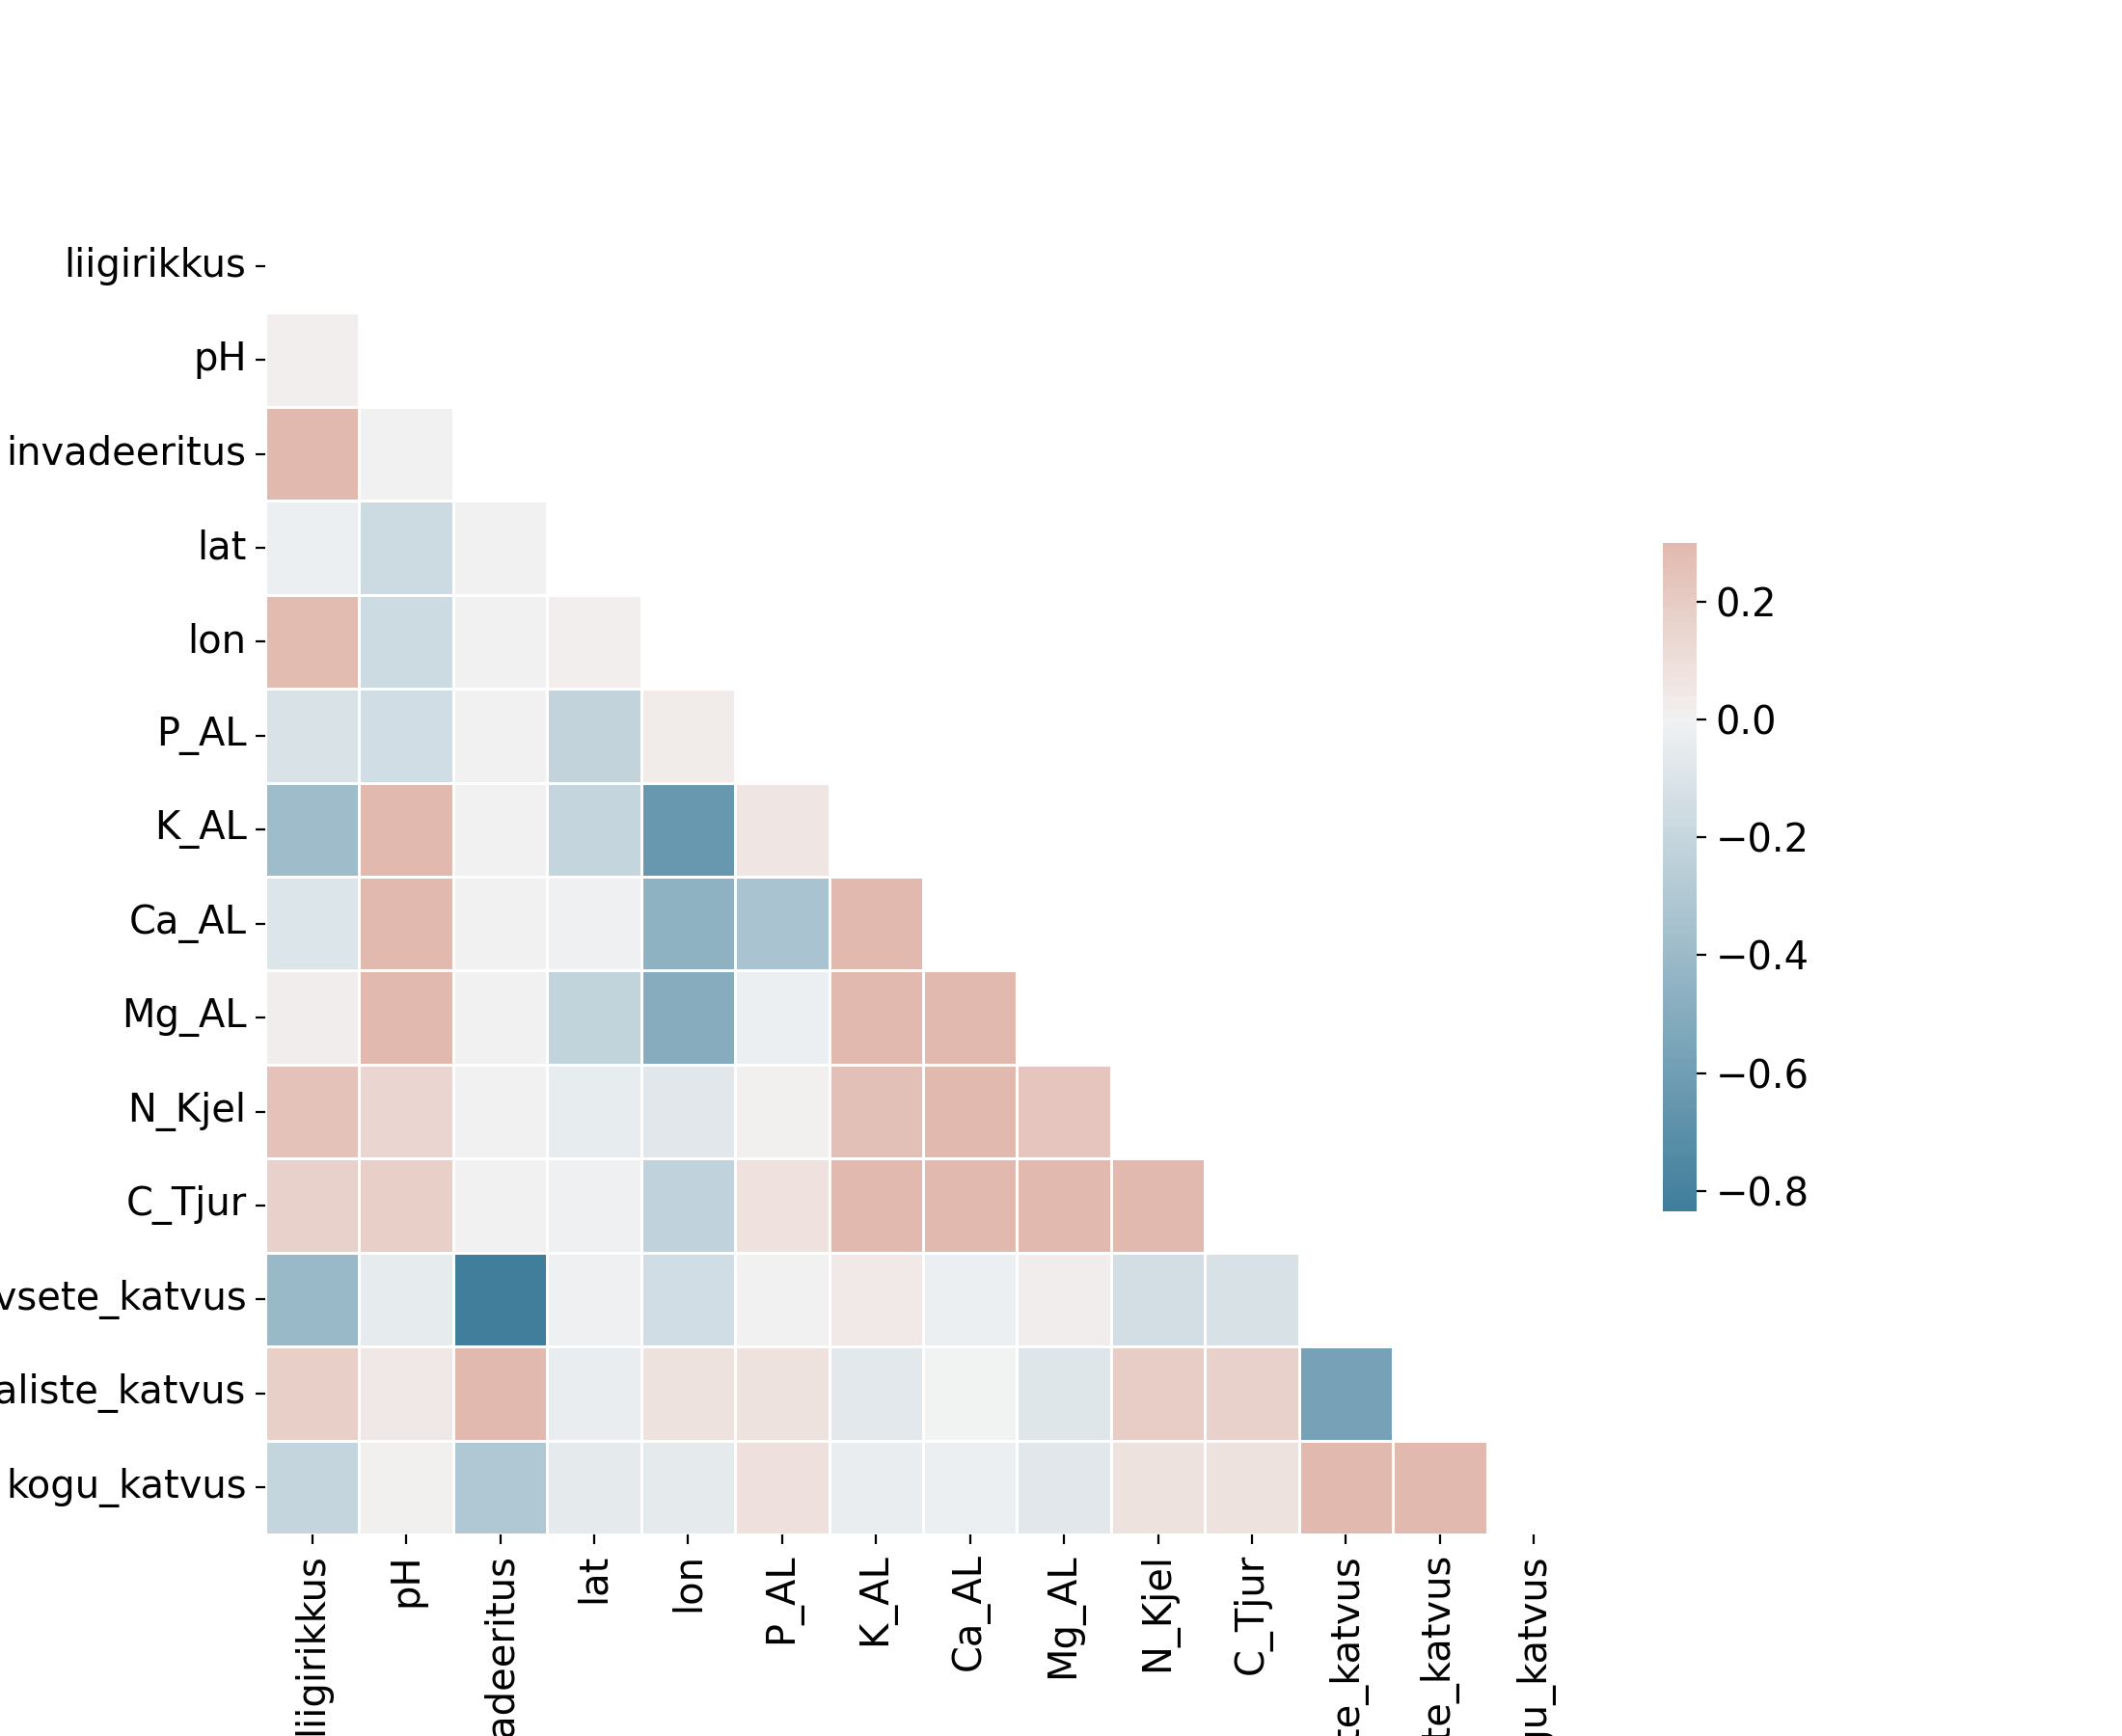

In [28]:
# Compute the correlation matrix
corr = väiksem_asi.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

a = -0.66 ± 0.11
b = 77.39 ± 4.58
s = 29.93


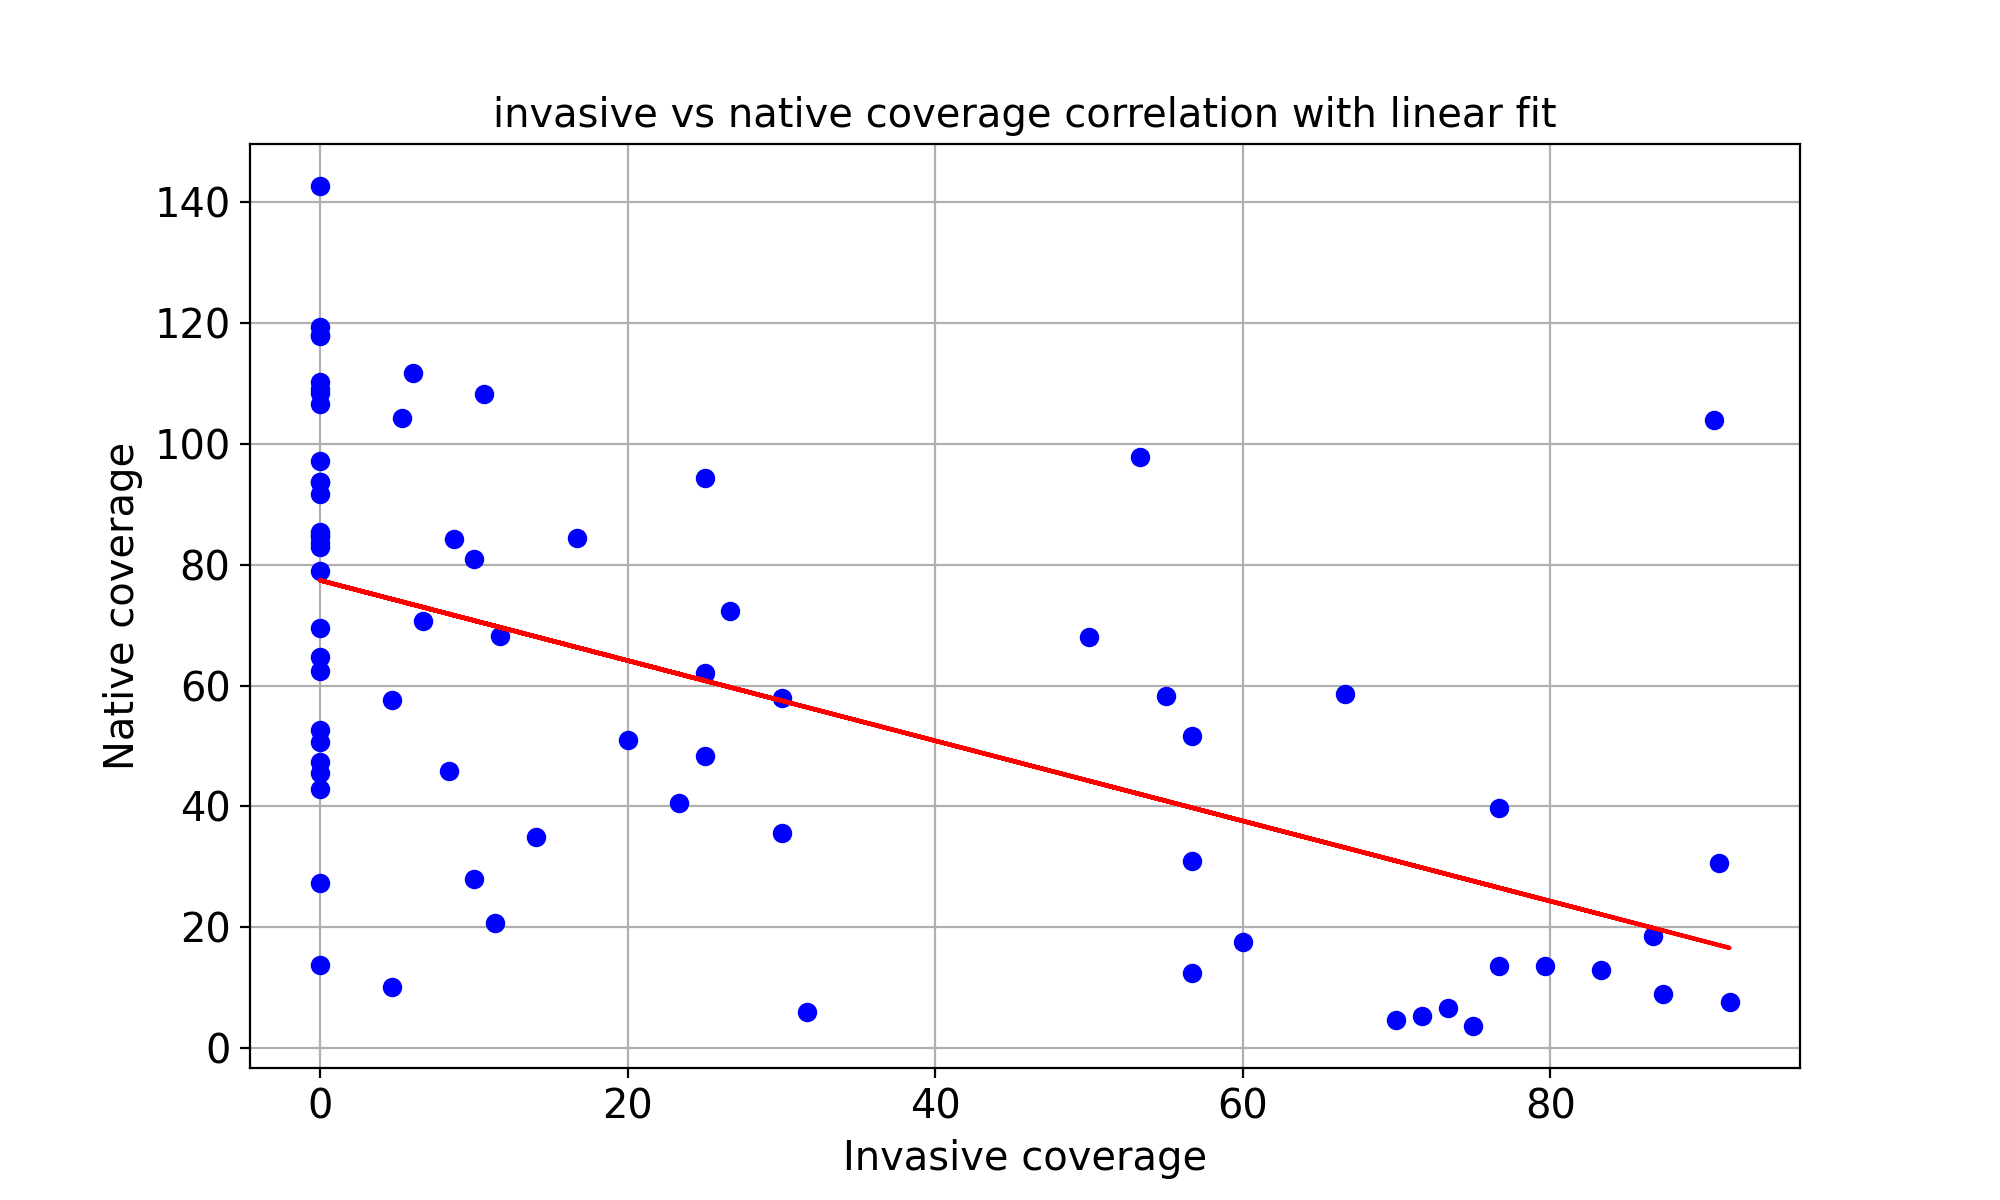

In [34]:
X=väiksem_asi.invasiivsete_katvus
Y=väiksem_asi.tavaliste_katvus

# linear fit
a, b, _, _, ua = linregress(X, Y)
Y1 = a * X + b
s = np.sqrt( ((Y - a * X - b)**2).sum() / (len(X) - 2) )
ub = np.sqrt( s**2 / len(X) + (X.mean() * ua)**2 )


print( 'a = %.2f ± %.2f' % (a, ua) )
print( 'b = %.2f ± %.2f' % (b, ub) )
print( 's = %.2f' % s ) #standard deviation 


plt.plot(X, Y, 'bo')
plt.plot(X, Y1, 'r-')
plt.xlabel('Invasive coverage')
plt.ylabel('Native coverage')
plt.title('invasive vs native coverage correlation with linear fit')
plt.grid()
plt.show()